In [1]:
library(tidyverse)
library(repr)
options(repr.matrix.max.rows = 6)
library(ggplot2)
library(tidymodels)
library(dplyr)
library(themis)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

**Proposed specific question:** does played_hours influence whether or not people subscribe?
Can we predict whether or not someone will subscribe to the newsletter based on how much they've played in Plaicraft?

In [2]:
set.seed(12)

players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [3]:
set.seed(12)

mod_players <- players |>
                select (subscribe, played_hours, experience) |>
                mutate (subscribe = as_factor(subscribe),
                        experience = recode(experience, Beginner = 1, Amateur = 2, Regular = 3, Pro = 4, Veteran = 5)) 
mod_players

subscribe,played_hours,experience
<fct>,<dbl>,<dbl>
TRUE,30.3,4
TRUE,3.8,5
FALSE,0.0,5
⋮,⋮,⋮
FALSE,0.0,2
FALSE,2.3,2
TRUE,0.2,4


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.5175041,5,0.03025870,Preprocessor1_Model01
2,roc_auc,binary,0.5217339,5,0.02833102,Preprocessor1_Model01
3,accuracy,binary,0.4361084,5,0.04112917,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
99,roc_auc,binary,0.4969968,5,0.04611618,Preprocessor1_Model98
100,accuracy,binary,0.5015928,5,0.06433796,Preprocessor1_Model99
100,roc_auc,binary,0.4894365,5,0.04309054,Preprocessor1_Model99


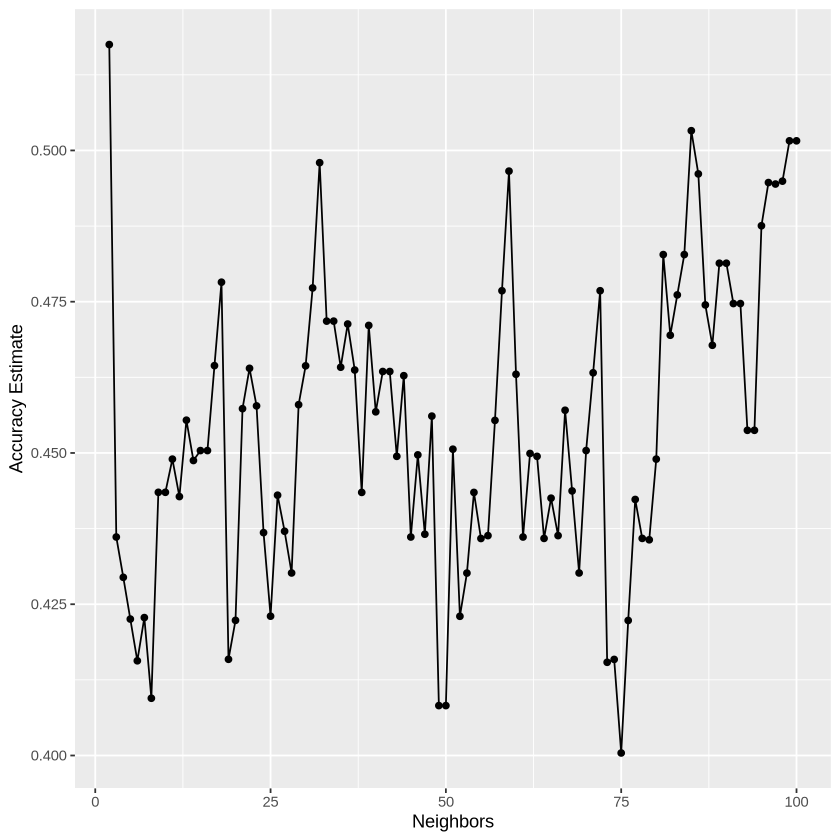

In [4]:
# K-nn Tuning + upsample
set.seed(12)
players_split <- mod_players |> 
                    initial_split (prop = 0.75, strata = subscribe) 

players_training <- training (players_split)
players_testing <- testing (players_split)

recipe_with_step <- recipe(subscribe ~ ., data = players_training) |>
                        step_center(all_predictors()) |>
                        step_scale(all_predictors()) |>
                        step_upsample (subscribe , over_ratio = 1) 

knn_spec_tune <- nearest_neighbor (weight_func = "rectangular", neighbors = tune()) |>
                    set_engine("kknn") |>
                    set_mode ("classification")

vfold <- vfold_cv(players_training, v = 5, strata = subscribe)

knn_grid <- tibble(neighbors = seq(from = 2, to = 100, by = 1))

knn_results <- workflow() |>
                  add_recipe(recipe_with_step) |>
                  add_model(knn_spec_tune) |>
                  tune_grid(resamples = vfold, grid = knn_grid)|>
                  collect_metrics()

knn_results
# Fix issue with extracting neighbors and mean accuracy
accuracies <- knn_results |>
                  filter(.metric == "accuracy") |>
                  select(neighbors, mean = mean) |>  # Ensure correct column selection
                  mutate(neighbors = as.numeric(neighbors), mean = as.numeric(mean))

# Plot accuracy vs. number of neighbors
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = "Neighbors", 
                       y = "Accuracy Estimate") 
             
cross_val_plot

In [5]:
set.seed(12)
precision_recipe <- recipe(subscribe ~ ., data = players_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors()) 

# for 2 neighbors
knn_2 <- nearest_neighbor (weight_func = "rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode ("classification")

fit_2 <- workflow() |>
    add_recipe (precision_recipe) |>
    add_model (knn_2) |>
    fit(data = players_training)

predictions_2 <- predict (fit_2, new_data = players_testing) |>
    bind_cols (players_testing)

metrics_2 <- predictions_2 |>
    metrics(truth = subscribe, estimate = .pred_class)

conf_mat_2 <- predictions_2 |>
    conf_mat (truth = subscribe, estimate = .pred_class) 

conf_mat_2

          Truth
Prediction FALSE TRUE
     FALSE    12   28
     TRUE      1    8

In [6]:
set.seed(12)
#for 4 neighbors

knn_4 <- nearest_neighbor (weight_func = "rectangular", neighbors = 4) |>
    set_engine("kknn") |>
    set_mode ("classification")

fit_4 <- workflow() |>
    add_recipe (precision_recipe) |>
    add_model (knn_4) |>
    fit(data = players_training)

predictions_4 <- predict (fit_4, new_data = players_testing) |>
    bind_cols (players_testing)

metrics_4 <- predictions_4 |>
    metrics(truth = subscribe, estimate = .pred_class)

conf_mat_4 <- predictions_4 |>
    conf_mat (truth = subscribe, estimate = .pred_class)

conf_mat_4

          Truth
Prediction FALSE TRUE
     FALSE    10   26
     TRUE      3   10

In [7]:
set.seed(12)
#for 6 neighbors

knn_6 <- nearest_neighbor (weight_func = "rectangular", neighbors = 6) |>
    set_engine("kknn") |>
    set_mode ("classification")

fit_6 <- workflow() |>
    add_recipe (precision_recipe) |>
    add_model (knn_6) |>
    fit(data = players_training)

predictions_6 <- predict (fit_6, new_data = players_testing) |>
    bind_cols (players_testing)

metrics_6 <- predictions_6 |>
    metrics(truth = subscribe, estimate = .pred_class)

conf_mat_6 <- predictions_6 |>
    conf_mat (truth = subscribe, estimate = .pred_class)
conf_mat_6

          Truth
Prediction FALSE TRUE
     FALSE     9   23
     TRUE      4   13

In [8]:
set.seed(12)
#for 10 neighbors

knn_10 <- nearest_neighbor (weight_func = "rectangular", neighbors = 10) |>
                    set_engine("kknn") |>
                    set_mode ("classification")

fit_10 <- workflow() |>
    add_recipe (precision_recipe) |>
    add_model (knn_10) |>
    fit(data = players_training)

predictions_10 <- predict (fit_10, new_data = players_testing) |>
    bind_cols (players_testing)

metrics_10 <- predictions_10 |>
    metrics(truth = subscribe, estimate = .pred_class)

conf_mat_10 <- predictions_10 |>
    conf_mat (truth = subscribe, estimate = .pred_class)

conf_mat_10

          Truth
Prediction FALSE TRUE
     FALSE     4   16
     TRUE      9   20

In [9]:
set.seed(12)

precision_2 <- 10/(10 + 21)
recall_2 <- 10/(10 + 3)

precision_3 <- 5/(5 + 18)
recall_3 <- 5/(5 + 8)

precision_4 <- 7/(7 + 21)
recall_4 <- 7/(7 + 6)

precision_6 <- 7/(7 + 19)
recall_6 <- 7/(7 + 6)

precision_10 <- 4/(4 + 10)
recall_10 <- 4/(4 + 9)

metrics_df <- tibble("k" = c(2, 3, 4, 6, 10), 
                     "precision" = c(precision_2, precision_3, precision_4, precision_6, precision_10),
                     "recall" = c(recall_2, recall_3, recall_4, recall_6, recall_10))
metrics_df

max_recall <- metrics_df |>
    select(k, recall) |>
    arrange(desc(recall)) |>
    slice(1) 
max_recall

k,precision,recall
<dbl>,<dbl>,<dbl>
2,0.3225806,0.7692308
3,0.2173913,0.3846154
4,0.2500000,0.5384615
6,0.2692308,0.5384615
10,0.2857143,0.3076923


k,recall
<dbl>,<dbl>
2,0.7692308


In [10]:
set.seed(12)

optimal_k <- 2

final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = optimal_k) |>
    set_engine("kknn") |>
    set_mode("classification")

final_fit <- workflow() |>
    add_recipe(precision_recipe) |>
    add_model(final_spec) |>
    fit(data = players_training)

final_preds <- predict(final_fit, new_data = players_testing) |>
    bind_cols(players_testing)

final_accuracy <- final_preds |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()

final_matrix <- final_preds |>
    conf_mat (truth = subscribe, estimate = .pred_class)

final_matrix
final_accuracy

          Truth
Prediction FALSE TRUE
     FALSE    12   28
     TRUE      1    8

[1] 0.4081633

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


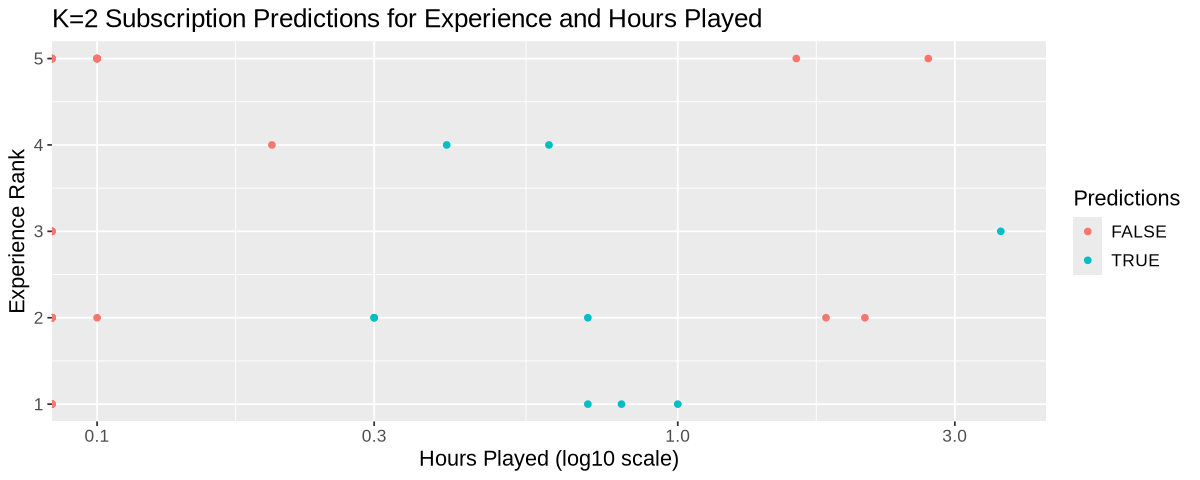

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


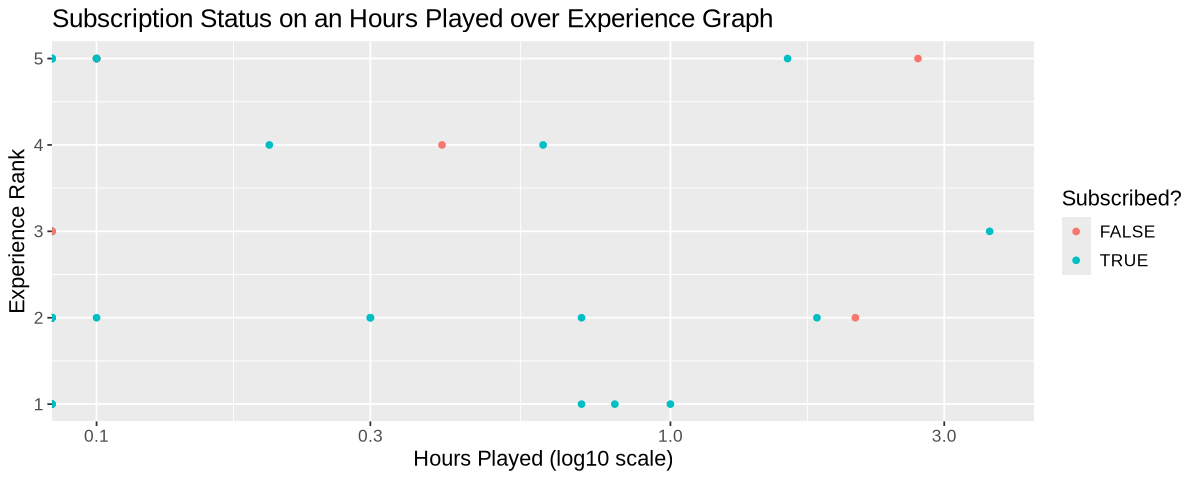

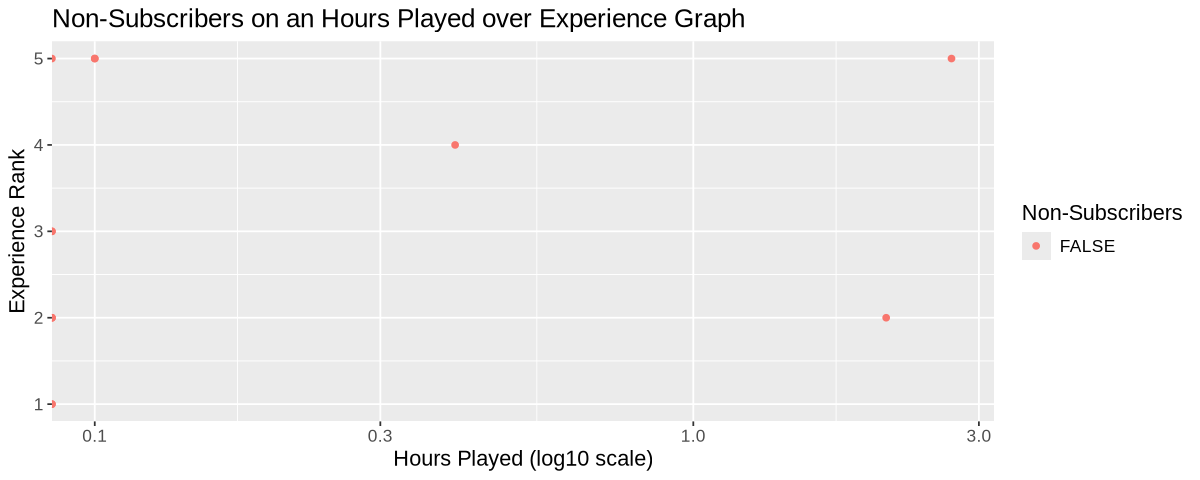

In [24]:
set.seed(12)
options(repr.plot.width = 10, repr.plot.height = 4)
# Visualization
k_2_preds <- predictions_2 |>
    ggplot(aes(x = played_hours, y = experience, color = .pred_class)) +
    geom_point() +
    labs(x = "Hours Played (log10 scale)", y = "Experience Rank", color = "Predictions", title = "K=2 Subscription Predictions for Experience and Hours Played") +
    scale_x_log10() +
    theme(text = element_text(size = 13))
k_2_preds

k_2_real <- players_testing |>
    ggplot(aes(x = played_hours, y = experience, color = subscribe)) +
    geom_point() +
    labs(x = "Hours Played (log10 scale)", y = "Experience Rank", color = "Subscribed?", title = "Subscription Status on an Hours Played over Experience Graph") +
    scale_x_log10() +
    theme(text = element_text(size = 13))
k_2_real

k_falses_plotted <- players_testing |>
    filter(subscribe == "FALSE") |>
    ggplot(aes(x = played_hours, y = experience, color = subscribe)) +
    geom_point() +
    labs(x = "Hours Played (log10 scale)", y = "Experience Rank", color = "Non-Subscribers", title = "Non-Subscribers on an Hours Played over Experience Graph") +
    scale_x_log10() +
    theme(text = element_text(size = 13))
k_falses_plotted

**Discussion:**
   
Using a k-nn classification model maximizing for precision, we obtained a model with an optimal *k* (2 nearest neighbours) and 79% precision value. After splitting the data, we first created a cross-validation k-tuning model to evaluate accuracy with *k*. Not only was this model redundant, as it was most accurate when we predicted "TRUE" for every single observation, but it also failed to capture the important aspects of the inquiry question. We figured developpers would be most interested in non-subscribers, so they could figure out why people are not subscribing and offer subscribtion incentives that would cater to non-subscribers in efforts to get as many people subscribed as possible. Thus, we felt it made sense for our model to sophistocatedly predict which people were *not* subscribed, and we chose precision as the primary metric we would optimize for. After trying multiple *k*s, we produced precision and recall values in a data frame and selected the *k* with the highest precision.

A result of 79% is reasonable, and roughly what we could expect since our classes were so imbalanced. Considering it is significantly more than 50%, this data is useful to the developpers, as they can successfully predict 4 of 5 non-subscribers based on how much they've played and use that data to learn about which people do not subscribe. From our first visualization (our predictions mapped), we see that the biggest cluster of predicted non-subscribers were those who had played very few hours in PlaiCraft, regardless of MineCraft experience. This is a reasonable assumption to make; those who have invested very little of their time into this project are least likely to subscribe, irrespective of their passion for MineCraft. What is more interesting, however, is the second cluster of non-subscribers at the high end of hours played in PlaiCraft. For these players, there is no reason why they should not have subscribed, and further efforts to figure out why they have not subscribed would make for impactful marketing research. This is likely the biggest impact of our model; we've predicted a cluster of high-commitment non-subscribers, and this logical discrepancy demands more research. Perhaps there are other factors at play; maybe these players are very young and won't receive emails, or perhaps their hours count is unusually high because they leave the game on in the background. These hypotheses could lead to new data analysis that seeks to unpack exclusively that cluster and explain it.

Finally, although our results lead to some interesting questions, they are hampered by the size and content of the data available. We only have 196 observations with 7 metrics being tracked, leading to a small and thus perhaps more inaccurate testing set. We also can't perform analysis on metrics like "How often do they check their email" or "How many other newsletters are they subscribed to," which means our results must be produced strictly by what we have accessible. Although our model is clearly functional, 79% is not overly powerful, and indeed, the cluster of high-commitment non-subscribers contains two fewer observations than our model suggests. While it is worth investigating, we need more data and a better model before we can pursue other questions related exclusively to that cluster.